In [ ]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import json

%matplotlib inline


base_dir = "C:\\Users\\jotag\\Documents\\phd\\listening experiment\\synthesis\\lib\\"

In [ ]:
# simulation settings
sr_etc = 50
etc_time_resolution = 1/sr_etc
speed_of_sound = 337
att_dB = 2.7/1000
#freqbands = pf.dsp.filter.fractional_octave_frequencies()
freqcy = 500 #freqbands[0]

In [ ]:
#radiosity object from file, whole wall-patch shabang
radi = sp.DirectionalRadiosityFast.from_file(
                filepath=os.path.join(base_dir,"SPatrizia_final.blend"),
                wall_auto_assembly=False,
                geometry_identifier="radi",
                )

In [ ]:
# set material properties
materials = np.array(["roof","grass","concrete"])
alpha = .1*np.ones((materials.shape[0]))
sigma = np.ones((materials.shape[0]))

# for i,material in enumerate(materials):
#     match material:
#         case "roof":
#             alpha[i] = 0.07
#             sigma[i] = 0.61391
#         case "concrete":
#             alpha[i] = 0.04
#             sigma[i] = 0.03
#         case "grass":
#             alpha[i] = 0.28
#             sigma[i] = 0.25



C:\Users\jotag\AppData\Local\Temp\ipykernel_22676\1017297104.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  samples = pf.samplings.sph_gaussian(16)
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\classes\coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order


<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

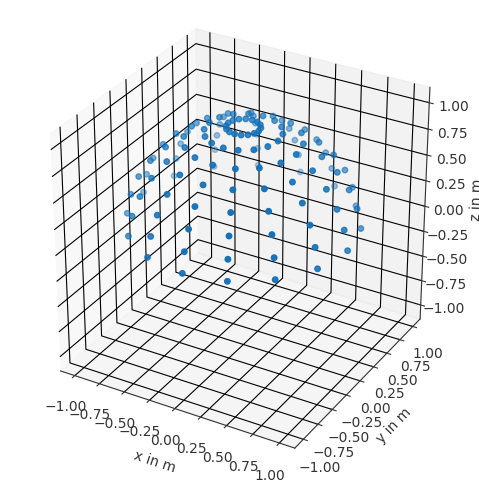

In [ ]:
# set brdfs
samples = pf.samplings.sph_gaussian(16)
brdf_sources = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_receivers = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_sources.show()


In [ ]:
# set brdfs
frequencies = np.array([freqcy])

# set air absorption
att_Np = att_dB*.115129254

radi.set_air_attenuation(
    pf.FrequencyData(
        att_Np*np.ones_like(frequencies),
        frequencies))

for i,material in enumerate(materials):

    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(sigma[i], frequencies),
        pf.FrequencyData(alpha[i], frequencies))

    # set directional scattering data
    radi.set_wall_brdf(
        np.where(radi._walls_material==material)[0],
        brdf,
        brdf_sources,
        brdf_receivers)


C:\Users\jotag\AppData\Local\Temp\ipykernel_22676\480024987.py:21: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radi.set_wall_brdf(


In [ ]:
radi.bake_geometry()

In [ ]:
source = pf.Coordinates(0,0,0)
# initialize source energy
radi.init_source_energy(source)

In [ ]:
radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=1,
        max_reflection_order=10,
        recalculate=True)


load trajectory


In [ ]:
with open(os.path.join(base_dir,
                       "Scenario_86",
                       "S86_trajectory.json"))as traj_file:
    trajectory_data = json.load(traj_file)

source_positions = np.array(trajectory_data["v_trajectory"]).T

In [ ]:
receiver = pf.Coordinates(source_positions[0],
                          source_positions[1],
                          source_positions[2])

etc_radiosity = radi.collect_energy_receiver_mono(
    receivers=receiver,direct_sound=True)

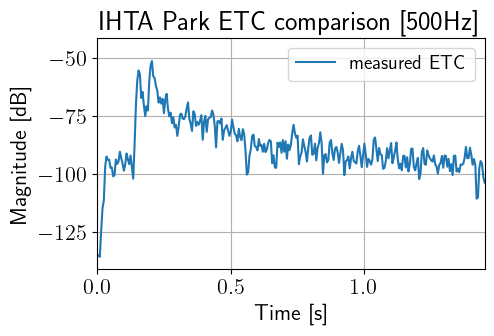

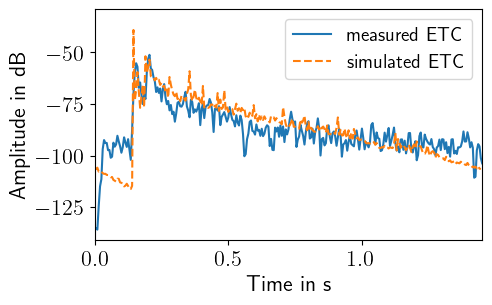

In [ ]:
figure,ax = plt.subplots(figsize=(5,3))
plt.legend(fontsize=14)
plt.ylim([-125,-40])
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Time [s]')
plt.grid()
plt.title(f"IHTA Park ETC comparison [{freqcy}Hz]")
figure.savefig(os.path.join(os.getcwd(),'figures','ETCs_ref.svg'),bbox_inches='tight')
plt.show()


figure,ax = plt.subplots(figsize=(5,3))
pf.plot.time(signal=etc_measurement,dB=True,log_prefix=10, ax=ax,
             label="measured ETC")
pf.plot.time(signal=etc_radiosity[0],dB=True,log_prefix=10, ax=ax,
             linestyle='--',label="simulated ETC")
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Time [s]')
plt.grid()
plt.legend(fontsize=14)

figure.savefig(os.path.join(os.getcwd(),'figures','ETCs_vs.svg'),bbox_inches='tight')
plt.show()

In [ ]:
%load_ext watermark
%watermark -v -m -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.1.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

numpy     : 1.26.4
sparrowpy : 0.1.0
pyfar     : 0.7.3
matplotlib: 3.10.1

